### c_Shuffle latent feature values  
Subset subtype, randomly select a value from each latent feature vector  
Collect selected values into a synthetic sample latent featue vector  
Decode the synthetic latent samples to synthetic gene expression space samples  
Predict on mix of real and synthetic data to make a superimposed learning curve  

In [6]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
DecisionTreeClassifier   ABCMeta     <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
RandomForestClassifier   ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
f1_score                 function    <function f1_score at 0x12b5e35e0>
figure                   function    <function figure at 0x14ac1c790>
glob                     module      <module 'glob' from '/Use<...>9/lib/python3.9/glob.py'>
mean                     function    <function mean at 0x12f77f0d0>
pd                       module      <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt                      module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
stdev                    function    <function stdev at 0x12f77f8b0>
train_test_split         function    <function train_test_split at 0x12b525700>


In [ ]:
# i-o dir for write-read of clf out / superimpose in?
# i_o/shuffle/latent_feature_sets/ for

In [ ]:
# idea: run the learning curve directly on the latent feature set
    # i.e. the encoded real samples
    # then compare to running the lc on the un-decoded synthetic latent samples

In [ ]:
# List of objects to have in memory:
    # trained decoder - BRCA - 
    # RF curve dict on input data - 
    # RF curve dict on decoded - 
    # RF curve diect on decoded synth* - 

### Imports, directory setup

In [5]:
import pandas as pd
import glob as glob

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from statistics import mean
from statistics import stdev

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [1]:
pwd

'/Users/karlberb/Documents/work/sample_count/synthetic_TCGA_data_gen/g_learning_curves'

In [3]:
ls

PDF.ipynb                            learning_curve_schematic.drawio
c_latent_sampling.ipynb              learning_curve_schematic.drawio.png
i_o/                                 shuffle.ipynb


### Target out dir:  
---------------
### i_o/shuffle  
--------------- 
Original version with decision tree was g_devel  
DT is also in 'RF again' section of c_latent_sampling

In [15]:
super_v = '_super_1'

### Data
MAD5k features either taken within or across the TCGA intersection features (less LGGGBM)  
Could also run the full GEXP files, miR, and METH or combos of these as feature sets  
See Setup section in <c_latent_sampling.ipynb> for synthetic index generation - done

In [7]:
acrss_pths = sorted(glob.glob('../g_devel/data_GEXP_5k_col_norm/*.tsv'))
brca_5k_across = pd.read_csv(acrss_pths[2], sep="\t", index_col=0)

In [ ]:
# acc_5k_across = pd.read_csv(five_k[0], sep="\t", index_col=0)

In [ ]:
# note: run different feature selection methods here

In [ ]:
wthn_pths = sorted(
    glob.glob(
        '/Users/karlberb/Documents/work/sample_count/synthetic_TCGA_data_gen/g_devel/data_5k/*.tsv'))
brca_5k_within = pd.read_csv(
    wthn_pths[2], sep = '\t', index_col = 0)

In [ ]:
# acc_5k_within = pd.read_csv(
#     mad5k_wthn_pths[0], sep = '\t', index_col = 0)

### Input GEXP to VAE Learning curve

#### Cohort and feature set toggles

In [8]:
df_to_rf = brca_5k_across # <---
feature_selection_method = 'across_cohort'

In [ ]:
# df_to_rf = acc_5k_across # <---
# feature_selection_method = 'across_cohort'

# df_to_rf = acc_5k_within # <---
# feature_selection_method = 'within_cohort'

# df_to_rf = brca_5k_within # <---
# feature_selection_method = 'within_cohort'

#### inpt RF Main

In [9]:
print('starting learning curve generation on labled feature set')
# inpt_RF_F1_dct = {}

inpt_RF_F1_means = {}
for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, plot up to 100?
# for smp_sz in list(range(15, 76, 5)): # ACC <---
    
    print(smp_sz)
    
    RF_output = []
    resmpl_count = 250
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_rf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)

    inpt_RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    
    # INPUT dict - raw F1 scores for error plot <note>
    # inpt_RF_F1_dct[smp_sz] = RF_output
    # break
print('Learning curve object generated, send to plot function')

starting learning curve generation on labled feature set
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
Learning curve object generated, send to plot function


In [ ]:
# check file naming on input learning curve, below
# Run at 100 latent dim

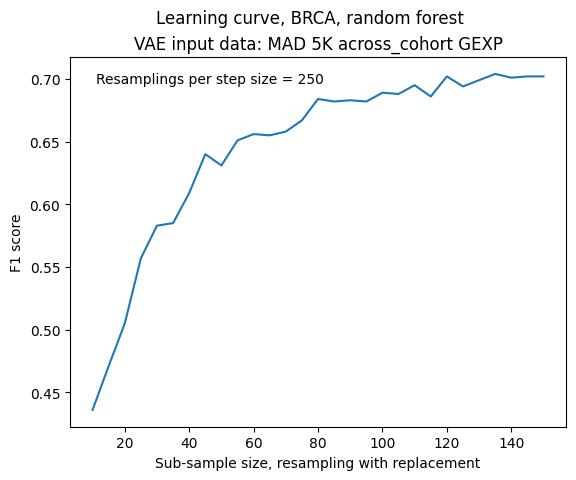

In [10]:
plt.plot(list(inpt_RF_F1_means.keys()),
       inpt_RF_F1_means.values(), label = 'Mean weighted F1')
plt.suptitle('Learning curve, '+df_to_rf.index.name+', random forest')
plt.title('VAE input data: MAD 5K '+feature_selection_method+' GEXP') # copy and modify 
plt.ylabel('F1 score')                                                # for decoded naming
plt.xlabel('Sub-sample size, resampling with replacement')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.15, .85), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.savefig(
    'i_o/shuffle/'+
    str(df_to_rf.index.name)+'_'+feature_selection_method+'_'+ # add decoded to naming
    str(list(inpt_RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+       # for post-VAE plots
    '_'+str(resmpl_count)+'-rsmpls'+
    '_super_1.png', bbox_inches = 'tight')

In [ ]:
# To template for double-overlay plot
    # Use that as template for triple-overlay

### VAE

#### Setup VAE

In [11]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [12]:
# Function set for leave one out loop
def compute_latent(x): # x:
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

#### Main VAE

In [23]:
feature_set = 'mad_5k_within'
decode_df = brca_5k_within
c = brca_5k_within.index.name
fit_on = 'BRCA'

In [ ]:
# Triple superimpose version 1: Across BRCA

In [13]:
feature_set = 'mad_5k_across' # smooth learning curve in original
decode_df = brca_5k_across
c = brca_5k_across.index.name
fit_on = 'BRCA'

In [ ]:
# ^ for super v1

In [27]:
feature_set = 'mad_5k_within'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_within

In [29]:
feature_set = 'mad_5k_across'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_across

In [ ]:
# <note> batch size
# <note> latent dim

Instructions for updating:
Colocations handled automatically by placer.
Metal device set to: Apple M1 Max


2022-11-29 08:09:55.728576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-29 08:09:55.728692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-29 08:09:55.732578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-29 08:09:55.736352: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-29 08:09:55.736950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-29 08:09:55.750305: I tensorflow/core/grappler/optimizers/custom_graph

Decode cohort trained on self using mad_5k_across feature set experiment done


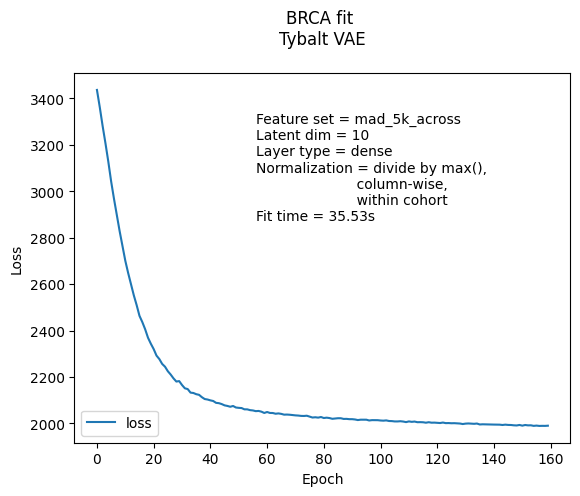

In [16]:
# Decode all samples after training on self with MAD 5k taken
  # either within or across cohort
# adapted from c_latent_sampling in g_learning curves

features = decode_df.columns[1:] # direct decode, will need fitting / dedoding frames

original_dim = len(features)
feature_dim = len(features)
latent_dim = 10               # Toggle here, to plot labels!

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

epochs=160

fit_start = time.time()
history = vae.fit(decode_df.iloc[:, 1:],  #       <-------- fit the VAE on object toggled here
            epochs=epochs, batch_size=50, shuffle=True,
            callbacks=[WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss")

plt.title(
    c+' fit '+
    '\nTybalt VAE\n'
         )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('Feature set = '+feature_set+
             '\nLatent dim = '+str(latent_dim)+
             '\nLayer type = dense'+
             '\nNormalization = divide by max(),\n'+
             '                       column-wise,\n'+
             '                       within cohort'+
             '\nFit time = '+str(round(fit_end,2 ))+'s',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            )

plt.legend(loc="lower left")
plt.savefig(
    'i_o/shuffle/'+c+'_'+
    'fit_on_'+fit_on+'_latent_dim.'+str(latent_dim)+
    # '_pltv-'+str(plt_v)+
    '_epochs.'+str(epochs)+'_'+
    feature_set+super_v+
    '.png', bbox_inches='tight') # version 18, norm within cohort
# plt.close()

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape=(latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = decode_df.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(decode_df.iloc[:, 1:])),
                       index=decode_df.index, columns=decode_df.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(decode_df.iloc[:, 1:]),
             index=decode_df.index,
                # columns=decode_df.iloc[:, 1:].columns # Columns are different because this is latent space
        )
latent_object.index.name = c
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv('i_o/shuffle/'+c+'_fit_on.'+fit_on+
                     '_latent_object_latent_dim.'+str(latent_dim)+
    '_epochs.'+str(epochs)+'_'+feature_set+super_v+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/shuffle/'+c+'_fit_on.'+fit_on+'_decoded_latent_dim.'+
    str(latent_dim)+
    '_epochs.'+str(epochs)+'_'+feature_set+super_v+
    '.tsv',
    sep = '\t')

print('Decode cohort trained on self using '+feature_set+' feature set experiment done')

### Classify on decoded samples  
'RF again' section in c_latent_sampling

#### Decoded clf setup

In [31]:
df_to_clf = decoded_labeled # across ACC (?)


In [64]:
df_to_clf = pd.read_csv(
    'i_o/shuffle/ACC_fit_on.ACC_decoded_latent_dim.10_epochs.155_mad_5k_across.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_across'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_across

In [41]:
df_to_clf = pd.read_csv(
    'i_o/shuffle/ACC_fit_on.ACC_decoded_latent_dim.10_epochs.155_mad_5k_within.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_within'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_within    

In [55]:
df_to_clf = pd.read_csv(
    'i_o/shuffle/BRCA_fit_on.BRCA_decoded_latent_dim.10_epochs.155_mad_5k_within.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_within'
c = 'BRCA'
fit_on = 'BRCA'
decode_df = brca_5k_within

In [17]:
# BRCA across
df_to_clf = pd.read_csv(
    'i_o/shuffle/BRCA_fit_on.BRCA_decoded_latent_dim.10_epochs.160_mad_5k_across_super_1.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_across'
c = 'BRCA'
fit_on = 'BRCA'
decode_df = brca_5k_across

In [18]:
df_to_clf.shape

(995, 5001)

#### Decoded clf main

In [ ]:
for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, plot up to 100?

In [ ]:
# <note> implement active learning

In [ ]:
# <note> using stock RF parameters

In [20]:
inpt_RF_F1_means

{10: 0.436,
 15: 0.471,
 20: 0.505,
 25: 0.557,
 30: 0.583,
 35: 0.585,
 40: 0.609,
 45: 0.64,
 50: 0.631,
 55: 0.651,
 60: 0.656,
 65: 0.655,
 70: 0.658,
 75: 0.667,
 80: 0.684,
 85: 0.682,
 90: 0.683,
 95: 0.682,
 100: 0.689,
 105: 0.688,
 110: 0.695,
 115: 0.686,
 120: 0.702,
 125: 0.694,
 130: 0.699,
 135: 0.704,
 140: 0.701,
 145: 0.702,
 150: 0.702}

In [21]:
# Superimpose dictionary 2 (decoded) samples build, version super 1

dec_RF_F1_means = {}

for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, mirror input steps above
    
    print(smp_sz)

    RF_output = []
    # resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
           
    dec_RF_F1_means[smp_sz] = round(mean(RF_output), 3)

print('brca across super 1 done')

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
brca across super 1 done


In [22]:
feature_set

'mad_5k_across'

In [23]:
fit_on

'BRCA'

In [24]:
df_to_clf.index.name

'BRCA'

In [25]:
len(inpt_RF_F1_means)

29

In [26]:
len(dec_RF_F1_means)

29

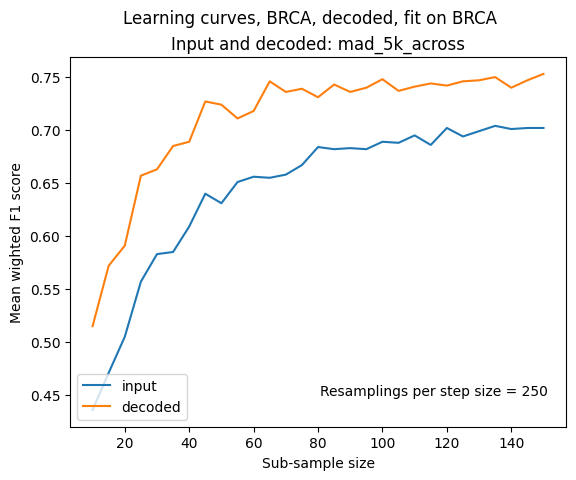

In [27]:
# Superimpose input on decoded
    # Using two dicts:
        # inpt_RF_F1_means
        # dec_RF_F1_means

plt.plot(list(inpt_RF_F1_means.keys()),
       inpt_RF_F1_means.values(),label='input')
plt.plot(list(dec_RF_F1_means.keys()),
       dec_RF_F1_means.values(),label='decoded')
# plt.plot(list(dec_RF_F1_means.keys()),
#        dec_RF_F1_means.values(),label='decoded')

plt.suptitle('Learning curves, '+df_to_clf.index.name+', decoded, fit on '+
             df_to_clf.index.name)
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Input and decoded: ' + feature_set) # across or within cohorts
plt.ylabel('Mean wighted F1 score')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .2), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc="lower left")
plt.savefig(
    'i_o/shuffle/super_1/'+
    str(df_to_clf.index.name)+'.inpt_and_dec_fit_on.'+fit_on +'_'+feature_set+'_'+
    str(list(inpt_RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+
    '_'+'rsmpls.'+str(resmpl_count)+
    '_super_1.png', bbox_inches = 'tight')

In [ ]:
# <note> what does this mean for generalization?

### Shuffle latent feature values  
Generate synthetic sample latent feature vector

#### Synth setup and data templates

In [ ]:
# devel shuffle:

In [ ]:
chrt = 'ACC'
latent_obj = pd.read_csv(
    'i_o/shuffle/latent_feature_sets/ACC_fit_on.ACC_latent_object_latent_dim.10_epochs.155_mad_5k_across.tsv',
        sep = '\t', index_col = 0)

In [ ]:

latent_obj = pd.read_csv(
    'i_o/shuffle/latent_feature_sets/i_o/shuffle/ACC_fit_on.ACC_latent_object_latent_dim.10_epochs.155_mad_5k_within.tsv',
        sep = '\t', index_col = 0)

In [ ]:
# Super 1 production:
    # Try 100 dims next

In [28]:
chrt = 'BRCA'
latent_obj = pd.read_csv(
    'i_o/shuffle/BRCA_fit_on.BRCA_latent_object_latent_dim.10_epochs.160_mad_5k_across_super_1.tsv',
        sep = '\t', index_col = 0)

In [ ]:
i_o/shuffle/BRCA_fit_on.BRCA_latent_object_latent_dim.10_epochs.155_mad_5k_across.tsv

In [ ]:
i_o/shuffle/BRCA_fit_on.BRCA_latent_object_latent_dim.10_epochs.155_mad_5k_within.tsv

#### Boilerplate

In [29]:
chrt = 'BRCA'
latent_obj = pd.read_csv(
    'i_o/shuffle/BRCA_fit_on.BRCA_latent_object_latent_dim.10_epochs.160_mad_5k_across_super_1.tsv',
        sep = '\t', index_col = 0)

In [30]:
latent_obj.shape # 10 dimensional latent feature object for BRCA across, this goes to triple super plot
    # after decoding and learning curve prediction object generation

(995, 11)

#### Synth main

In [42]:
del(synth_samples_per_subtype)

In [43]:
synth_ndx_strt = 0

# synth_samples_per_subtype = 100 # no, make dynamic

synth_full_frame = pd.DataFrame()

# Take the reset starting index position from end of loop to create next synthetic subtype set

for subtype in sorted(latent_obj.Labels.unique()): # Subset the latent feature frame on each subtype
    
    print(subtype)
    
    # break
    
    sub = latent_obj[latent_obj.Labels == subtype]
    synth_lat_feat_vec = []
    
    sub_len = len(sub)
    
    synth_index = ['SYNTH-' + chrt + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              sub_len + synth_ndx_strt))]]
    # break
    
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    for lat_feat in sub.columns[1:]:               # Go through the subtype latent feature set,
        # print(lat_feat)                            # skipping the Labels column
        lat_col = sub.loc[:, lat_feat]
        
        rand_lat_feat_vals = lat_col.sample(
            len(sub), replace = True, # <note> can toggle replacement off if taking less than number samples
            # index = synth_index
        ) # *
        rand_lat_feat_vals.index = synth_index
        synth_sub_frame = pd.concat(
            [synth_sub_frame, rand_lat_feat_vals], axis = 1)
        # break
    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0)
    # break
    synth_ndx_strt = synth_ndx_strt + len(sub)
    # break

BRCA_1
BRCA_2
BRCA_3
BRCA_4


In [44]:
synth_full_frame # This is an ecoded synthetic object

,Labels,0,1,2,3,4,5,6,7,8,9
SYNTH-BRCA-00000,BRCA_1,0.390813,0.000000,2.292801,0.000000,3.275994,3.128514,5.065894,2.854327,2.230490,2.323371
SYNTH-BRCA-00001,BRCA_1,0.000000,0.000000,1.100748,1.125745,0.000000,0.000000,1.039768,1.945289,0.354525,2.737834
SYNTH-BRCA-00002,BRCA_1,0.000000,0.508648,0.000000,0.000000,3.017291,0.343181,0.000000,0.529828,1.695792,1.987387
SYNTH-BRCA-00003,BRCA_1,1.746946,0.937041,2.024484,1.799238,0.960860,2.037657,0.000000,1.223458,2.646553,1.081152
SYNTH-BRCA-00004,BRCA_1,0.000000,0.000000,2.059792,1.751955,1.152250,1.448333,0.000000,1.305048,2.778963,2.277759
...,...,...,...,...,...,...,...,...,...,...,...
SYNTH-BRCA-00990,BRCA_4,2.012911,1.337201,3.275453,0.683998,0.000000,0.000000,0.000000,1.570898,0.000000,2.361673
SYNTH-BRCA-00991,BRCA_4,3.478880,1.229306,3.913834,0.522975,0.000000,0.000000,0.000000,1.410941,5.086558,1.534763
SYNTH-BRCA-00992,BRCA_4,2.320537,1.360246,3.895362,1.588280,0.643470,0.000000,1.760524,3.374522,4.897415,0.000000
SYNTH-BRCA-00993,BRCA_4,1.309653,1.925288,1.531892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.361673


#### Sythetic index generation

In [153]:
synth_full_frame.to_csv('i_o/shuffle/synthetic_feature_sets/'+
                        chrt+'_'+
                        str(synth_samples_per_subtype)+'_per_sbtyp.tsv',
                        sep = '\t')

In [ ]:
# write / read the synthetic latent feature object - write part is done, cont blw
# then decode it
# Then run a random forest on it, custom synthetic subsampling range
# Then plot the learning curve

In [154]:
synth_full_frame_test = pd.read_csv('i_o/shuffle/synthetic_feature_sets/'+
                        chrt+'_'+
                        str(synth_samples_per_subtype)+'_per_sbtyp.tsv',
                        sep = '\t',
                                   index_col = 0)

### Decode synthetic samples

In [ ]:
# skipping i-o

In [ ]:
decode_df

In [46]:
encoder.predict(decode_df.iloc[:, 1:]).shape

(995, 10)

In [47]:
type(encoder.predict(decode_df.iloc[:, 1:]))

numpy.ndarray

In [48]:
synth_full_frame.iloc[:, 1:]

,0,1,2,3,4,5,6,7,8,9
SYNTH-BRCA-00000,0.390813,0.000000,2.292801,0.000000,3.275994,3.128514,5.065894,2.854327,2.230490,2.323371
SYNTH-BRCA-00001,0.000000,0.000000,1.100748,1.125745,0.000000,0.000000,1.039768,1.945289,0.354525,2.737834
SYNTH-BRCA-00002,0.000000,0.508648,0.000000,0.000000,3.017291,0.343181,0.000000,0.529828,1.695792,1.987387
SYNTH-BRCA-00003,1.746946,0.937041,2.024484,1.799238,0.960860,2.037657,0.000000,1.223458,2.646553,1.081152
SYNTH-BRCA-00004,0.000000,0.000000,2.059792,1.751955,1.152250,1.448333,0.000000,1.305048,2.778963,2.277759
...,...,...,...,...,...,...,...,...,...,...
SYNTH-BRCA-00990,2.012911,1.337201,3.275453,0.683998,0.000000,0.000000,0.000000,1.570898,0.000000,2.361673
SYNTH-BRCA-00991,3.478880,1.229306,3.913834,0.522975,0.000000,0.000000,0.000000,1.410941,5.086558,1.534763
SYNTH-BRCA-00992,2.320537,1.360246,3.895362,1.588280,0.643470,0.000000,1.760524,3.374522,4.897415,0.000000
SYNTH-BRCA-00993,1.309653,1.925288,1.531892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.361673


In [50]:
synth_decoded = pd.DataFrame(decoder.predict( # wild part:
    synth_full_frame.iloc[:, 1:]
                                            ),
                       index=synth_full_frame.index, # Putting on synthetic index
                             
                             columns=decode_df.iloc[:, 1:].columns) # Putting on og columns

In [51]:
synth_full_frame.Labels

SYNTH-BRCA-00000    BRCA_1
SYNTH-BRCA-00001    BRCA_1
SYNTH-BRCA-00002    BRCA_1
SYNTH-BRCA-00003    BRCA_1
SYNTH-BRCA-00004    BRCA_1
                     ...  
SYNTH-BRCA-00990    BRCA_4
SYNTH-BRCA-00991    BRCA_4
SYNTH-BRCA-00992    BRCA_4
SYNTH-BRCA-00993    BRCA_4
SYNTH-BRCA-00994    BRCA_4
Name: Labels, Length: 995, dtype: object

In [52]:
synth_decoded_labeled = pd.concat( [pd.DataFrame(synth_full_frame.Labels), synth_decoded] , axis =1)

In [53]:
synth_decoded_labeled

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
SYNTH-BRCA-00000,BRCA_1,0.000012,0.000144,0.024817,0.022086,0.000040,0.000032,0.000007,0.000612,0.001147,...,0.094124,0.104721,0.169636,0.080348,0.052946,0.160961,0.037551,0.054123,0.089139,0.007544
SYNTH-BRCA-00001,BRCA_1,0.008581,0.022428,0.184535,0.192103,0.014098,0.011539,0.008249,0.051224,0.029526,...,0.227959,0.284521,0.301236,0.240515,0.218895,0.274187,0.140589,0.169843,0.216613,0.108834
SYNTH-BRCA-00002,BRCA_1,0.018230,0.032683,0.182864,0.217830,0.015063,0.012765,0.009975,0.045974,0.065260,...,0.231786,0.331236,0.330525,0.245590,0.241553,0.313353,0.135238,0.162285,0.206646,0.128832
SYNTH-BRCA-00003,BRCA_1,0.001349,0.003690,0.032196,0.046734,0.002034,0.001237,0.000650,0.007566,0.009486,...,0.164984,0.308102,0.225005,0.196226,0.192268,0.227603,0.081059,0.113695,0.173557,0.034653
SYNTH-BRCA-00004,BRCA_1,0.002249,0.004657,0.062201,0.077929,0.001899,0.001323,0.000917,0.008712,0.012443,...,0.180791,0.267140,0.245721,0.181587,0.181975,0.247667,0.092799,0.104881,0.170235,0.046920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SYNTH-BRCA-00990,BRCA_4,0.003131,0.009643,0.053688,0.083589,0.008500,0.004955,0.003531,0.026723,0.010469,...,0.202701,0.360203,0.270557,0.261342,0.236731,0.246069,0.074257,0.133981,0.195404,0.052408
SYNTH-BRCA-00991,BRCA_4,0.000637,0.001883,0.020870,0.048191,0.001390,0.000643,0.000370,0.005788,0.002470,...,0.180312,0.327472,0.217180,0.222699,0.194899,0.247915,0.037716,0.078725,0.155843,0.020206
SYNTH-BRCA-00992,BRCA_4,0.000122,0.000686,0.017729,0.038314,0.000468,0.000223,0.000079,0.002143,0.001315,...,0.155091,0.216939,0.194330,0.175291,0.135411,0.211592,0.034915,0.077526,0.140420,0.009715
SYNTH-BRCA-00993,BRCA_4,0.022738,0.046086,0.127127,0.146674,0.046886,0.033668,0.026312,0.106734,0.042832,...,0.258898,0.383441,0.312964,0.303377,0.277605,0.278383,0.145625,0.208558,0.254378,0.142579


In [ ]:
# to synth_clf object build for super 1 plot

In [ ]:
synth_full_frame

### Classify on synthetic samples

In [54]:
df_to_clf = synth_decoded_labeled

In [55]:
# Superimpose dictionary 2 (decoded) samples build, version super 1

# dec_RF_F1_means = {}
synth_RF_F1_means = {}

for smp_sz in list(range(10, 151, 5)): # BRCA <--- across run, mirror input steps above
    
    print(smp_sz)

    RF_output = []
    # resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
           
    synth_RF_F1_means[smp_sz] = round(mean(RF_output), 3)

print('brca_across clf dict 3, super 1 done')

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
brca_across clf dict 3, super 1 done


In [56]:
df_to_clf.index.name

In [58]:
df_to_clf.index.name = 'BRCA' # go back and insert this somewhere

In [59]:
df_to_clf.index.name # pre-super

'BRCA'

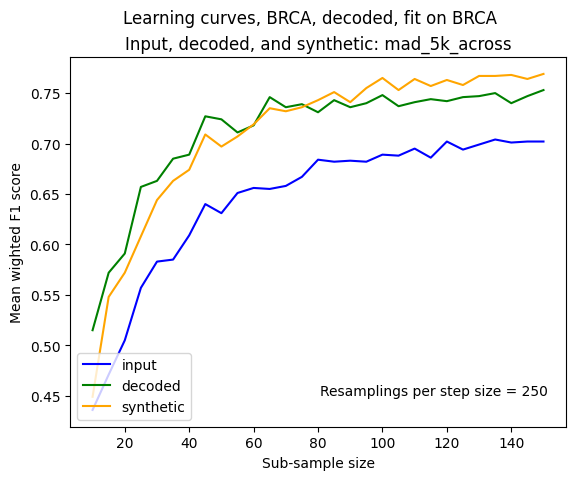

In [62]:
# Superimpose input on decoded
    # Using two dicts:
        # inpt_RF_F1_means
        # dec_RF_F1_means

plt.plot(list(inpt_RF_F1_means.keys()),
       inpt_RF_F1_means.values(),label='input', color = 'blue')
plt.plot(list(dec_RF_F1_means.keys()),
       dec_RF_F1_means.values(),label='decoded', color = 'green')
plt.plot(list(synth_RF_F1_means.keys()),
       synth_RF_F1_means.values(),label='synthetic', color = 'orange')

plt.suptitle('Learning curves, '+df_to_clf.index.name+', decoded, fit on '+
             df_to_clf.index.name)
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Input, decoded, and synthetic: ' + feature_set) # across or within cohorts
plt.ylabel('Mean wighted F1 score')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .2), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc="lower left")
plt.savefig(
    'i_o/shuffle/super_1/'+
    str(df_to_clf.index.name)+'.inpt_and_dec_fit_on.'+fit_on +'_'+feature_set+'_'+
    str(list(inpt_RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+
    '_'+'rsmpls.'+str(resmpl_count)+
    '_super_1_synth.png', bbox_inches = 'tight')

In [ ]:
# End shuffle super 1
# Main idea: Synthetic data generation demonstrated for improving cancer subtype prediction
# could be repurposed for cancer drug response prediction

# Case in point: took sample of ~25 subtypes, expanded cohort with synthetic gene experession samples
# improved mean F1 weighted subtype classification with synthetic data generationa

In [ ]:
# Next actions: - (priority)
    # audit the manuscript - 2
    # run on miR and METH data types
    # extract best model and feature set from big results matrix
    # Do a sample count, sort, and threshold on the 25 cohorts - 1
        # include LGGGBM?
    # Do some work directly on LGGGBM 

### Shuffle devel

In [ ]:
# End 2022-11-28, Monday afternoon
# Build-out the super position plots
    # work on file naming
# Last line of paper: can do better

# Class imbalance is optimization,
    # deal with later
    # maintaining class imbalanace could return closer to input F1
    # because the larger classes might be better defined

In [ ]:
target ouput dir:
i_o/shuffle/synthetic_feature_sets

In [ ]:
[str(
    item).zfill(
    5) for item in list(range(
    synth_ndx_strt, synth_samples_per_subtype + synth_ndx_strt,))] # production

In [ ]:
# Oringinal RF only learning curve block 


# DataFrame to Random Forest TOGGLE

# df_to_rf = acc_5k_across # <---
# feature_selection_method = 'across_cohort'

# df_to_rf = acc_5k_within # <---
# feature_selection_method = 'within_cohort'

# df_to_rf = brca_5k_within # <---
# feature_selection_method = 'within_cohort'

print('starting learning curve generation on labled feature set')
npt_RF_F1_dct = {}


RF_F1_means = {}
for smp_sz in list(range(50, 251, 10)): # BRCA <---
# for smp_sz in list(range(15, 76, 5)): # ACC <---
    
    print(smp_sz)
    # print(' ')
    
    stdev_lst = []
    mean_lst = []
    
    RF_output = []
    resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_rf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
        # print(RF_output)
        
        if len(RF_output) > 1:
            stdev_lst.append(stdev(RF_output))
            mean_lst.append(mean(RF_output))
        # Active learning insertion point    
           
    RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    
    # INPUT dict
    npt_RF_F1_dct[smp_sz] = RF_output
    # break
print('Learning curve object generated, send to plot function')

In [ ]:
# Decision tree inclusion template, simplify with using same variable 
# for clf in a loop
RF_F1_dct = {}
RF_F1_means = {}
DT_F1_means = {}
# for smp_sz in list(range(20, 251, 10)):
for smp_sz in list(range(15, 76, 5)):       # Toggle on for ACC  <---------
    
    print(smp_sz)
    # print(' ')
    
    stdev_lst = []
    mean_lst = []
    
    RF_output = []
    DT_output = []
    resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        DT_clf = DecisionTreeClassifier()
        RF_clf.fit(X_train, y_train)
        DT_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        DT_F1_scr = f1_score(y_test, DT_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
        DT_output.append(DT_F1_scr)
        
        if len(RF_output) > 1:
            stdev_lst.append(stdev(RF_output))
            mean_lst.append(mean(RF_output)) # running mean for active learning
           
    RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    DT_F1_means[smp_sz] = round(mean(DT_output), 3)
    RF_F1_dct[smp_sz] = RF_output
print('clf done')

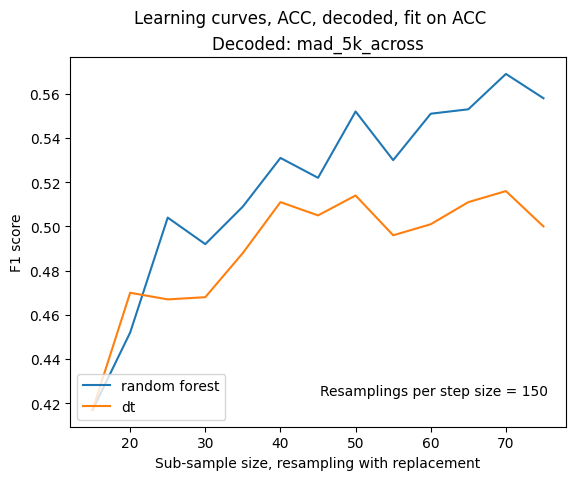

In [70]:
# DT overlay template
clf = 'random forest'
plt.plot(list(RF_F1_means.keys()),
       RF_F1_means.values(),label=clf)
plt.plot(list(DT_F1_means.keys()),
       DT_F1_means.values(),label='dt')
plt.suptitle('Learning curves, '+df_to_clf.index.name+', decoded, fit on '+
             df_to_clf.index.name)
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Decoded: ' + feature_set) # across or within cohorts
plt.ylabel('F1 score')
plt.xlabel('Sub-sample size, resampling with replacement')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .2), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc="lower left")
plt.savefig(
    'i_o/shuffle/decoded_curves/'+
    str(df_to_clf.index.name)+'.decoded_fit_on.'+fit_on +'_'+feature_set+'_'+
    str(list(RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+
    '_'+'rsmpls.'+str(resmpl_count)+
    '_v0.png', bbox_inches = 'tight')

In [ ]:
# <note> test preserving original subtype sample ratios

In [ ]:
# Syth original

synth_ndx_strt = 0
synth_samples_per_subtype = 100

synth_full_frame = pd.DataFrame()

# Take the reset starting index position from end of loop to create next synthetic subtype set
for subtype in sorted(latent_obj.Labels.unique()): # Subset the latent feature frame on each subtype
    print(subtype)
    sub = latent_obj[latent_obj.Labels == subtype]
    synth_lat_feat_vec = []
    
    synth_index = ['SYNTH-' + chrt + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_samples_per_subtype + synth_ndx_strt))]]
    # break
    
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    for lat_feat in sub.columns[1:]:               # Go through the subtype latent feature set,
        # print(lat_feat)                            # skipping the Labels column
        lat_col = sub.loc[:, lat_feat]
        
        rand_lat_feat_vals = lat_col.sample(
            synth_samples_per_subtype, replace = True,
            # index = synth_index
        ) # *
        rand_lat_feat_vals.index = synth_index
        synth_sub_frame = pd.concat(
            [synth_sub_frame, rand_lat_feat_vals], axis = 1)
        # break
    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0)
    # break
    synth_ndx_strt = synth_ndx_strt + synth_samples_per_subtype
    # break